#### Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm.auto import tqdm
import xgboost as xgb

#### Loading the data

Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.

In [55]:
df = pd.read_csv(r'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [56]:
columns=['latitude','longitude','housing_median_age','total_rooms','total_bedrooms',\
         'population','households','median_income','median_house_value','ocean_proximity']

In [57]:
df = df[columns]

In [58]:
df.fillna(0,inplace=True)

In [59]:
dv = DictVectorizer(sparse=False)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

#### Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`

In [60]:
dt =  DecisionTreeRegressor(max_depth=1)

In [61]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [62]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* 0.25
* 0.55
* 0.85


In [63]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [81]:
y_pred = rf.predict(X_val)
round(np.sqrt(mean_squared_error(y_val, y_pred)),2)

0.25

#### Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 55
- 75
- 150


In [65]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

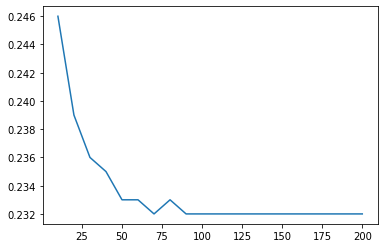

In [66]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [67]:
df_scores.sort_values(by='rmse',ascending=True).head(5)

,n_estimators,rmse
10,110,0.231518
11,120,0.231621
16,170,0.231629
19,200,0.231650
13,140,0.231692


#### Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [86]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

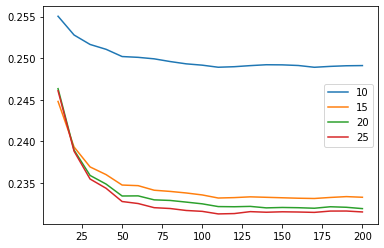

In [83]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

#### Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

In [68]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1,max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [69]:
rf.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [70]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance',ascending=False)

,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


#### Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same


In [71]:
features = dv.get_feature_names_out()
for i in features:
    features[list(features).index(i)] =i.replace('=','_').replace('<','')
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [72]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [73]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [74]:
scores = {}

In [75]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [76]:
scores['eta=0.3'] = parse_xgb_output(output)

In [77]:
scores

{'eta=0.3':     num_iter  train_auc  val_auc
 0          0    8.12733  8.13245
 1          5    1.40218  1.40741
 2         10    0.34481  0.35782
 3         15    0.23555  0.26044
 4         20    0.21580  0.24624
 5         25    0.20395  0.24099
 6         30    0.19440  0.23741
 7         35    0.18637  0.23562
 8         40    0.17983  0.23419
 9         45    0.17468  0.23279
 10        50    0.16934  0.23097
 11        55    0.16546  0.23039
 12        60    0.16177  0.22950
 13        65    0.15762  0.22857
 14        70    0.15323  0.22787
 15        75    0.15010  0.22755
 16        80    0.14564  0.22611
 17        85    0.14166  0.22579
 18        90    0.13892  0.22628
 19        95    0.13553  0.22630
 20        99    0.13299  0.22610}

In [78]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [79]:
scores['eta=0.1'] = parse_xgb_output(output)

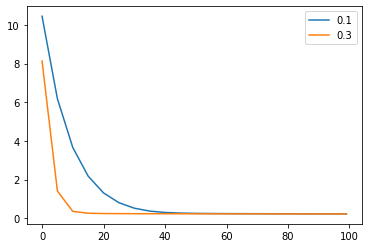

In [80]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()



(30.0, 100.0)

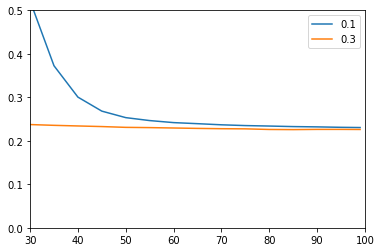

In [50]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

plt.ylim([0, 0.5])
plt.xlim([30, 100])